In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress the FutureWarning related to is_categorical_dtype from TargetEncoder
warnings.filterwarnings("ignore", category=FutureWarning)

<h1>Preprocessing</h1>

In [3]:
class MyTargetEncoder():
    def __init__(self, columns_to_target_encode, training_data):
        self.encoders = {}
        self.columns_to_target_encode = columns_to_target_encode
        for col in columns_to_target_encode:
            encoder = TargetEncoder()
            encoder.fit(training_data[col], training_data['monthly_rent'])
            self.encoders[col] = encoder
        
    def fit_data(self, encoded_data):
        for col, encoder in self.encoders.items():
            encoded_data[col] = encoder.transform(encoded_data[col])
        return encoded_data


def clean_data(data):
    cleaned_data = data
    cleaned_data = cleaned_data.drop(columns=['furnished', 'elevation', 'town', 'block', 'street_name', 'planning_area', 'subzone'])
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace(r'(2|3|4|5)-room|(\d) room', r'\1\2', regex=True)
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace('executive', '6')
    cleaned_data['flat_type'] = cleaned_data['flat_type'].astype(int)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].str[2:].str.replace('-', '', regex=False)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].astype(int)
    
    return cleaned_data


def encode_data(train_org, training_cleaned, valid_cleaned, testing_cleaned):
    # First Target Encoding
    
    columns_to_target_encode = ['flat_model']
    myTargetEncoder = MyTargetEncoder(columns_to_target_encode, train_org)
    
    training_encoded = myTargetEncoder.fit_data(training_cleaned)
    valid_encoded = myTargetEncoder.fit_data(valid_cleaned)
    testing_encoded = myTargetEncoder.fit_data(testing_cleaned)
    
    # Now, One-Hot Encoding
    
    # Prepare Model
    myOneHotEncoder = OneHotEncoder(sparse=False)
    myOneHotEncoder.fit(training_encoded[['region']])
    
    # Fit on train data
    tr1 = myOneHotEncoder.transform(training_encoded[['region']])
    tr2 = pd.DataFrame(tr1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    tr3 = pd.concat([training_encoded.reset_index(drop=True), tr2.reset_index(drop=True)], axis=1)

    training_encoded = tr3.drop(columns=["region"])
    
    # Fit on valid data
    va1 = myOneHotEncoder.transform(valid_encoded[['region']])
    va2 = pd.DataFrame(va1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    va3 = pd.concat([valid_encoded.reset_index(drop=True), va2.reset_index(drop=True)], axis=1)

    valid_encoded = va3.drop(columns=["region"])
    
    # Fit on test data
    te1 = myOneHotEncoder.transform(testing_encoded[['region']])
    te2 = pd.DataFrame(te1, columns=myOneHotEncoder.get_feature_names_out(['region']))
    te3 = pd.concat([testing_encoded.reset_index(drop=True), te2.reset_index(drop=True)], axis=1)

    testing_encoded = te3.drop(columns=["region"])
    
    return training_encoded, valid_encoded, testing_encoded

def scale_data(training_encoded, validation_encoded, testing_encoded):
    scaler = StandardScaler()
    training_scaled = scaler.fit_transform(training_encoded)
    validation_scaled = scaler.fit_transform(validation_encoded)
    testing_scaled = scaler.fit_transform(testing_encoded)
    return training_scaled, validation_scaled, testing_scaled

def preprocess_data(train_org, training_data_raw, valid_data_raw, testing_data_raw):
    
    training_cleaned = clean_data(training_data_raw)
    valid_cleaned = clean_data(valid_data_raw)
    testing_cleaned = clean_data(testing_data_raw)
    
    training_encoded, valid_encoded, testing_encoded = encode_data(train_org, training_cleaned, valid_cleaned, testing_cleaned)

    return training_encoded, valid_encoded, testing_encoded


<h1>Aux Data</h1>

In [4]:
def add_aux_data_count_in_radius(training_data_raw, training_coords, col_name, aux_data_raw, radius):
    geom_list_aux = [Point(lon,lat) for lon,lat in zip(aux_data_raw["longitude"], aux_data_raw["latitude"])]
    gdf_aux = gpd.GeoDataFrame(aux_data_raw, geometry=geom_list_aux, crs="EPSG:4326")

    # this uses the right projection to get the distance in m scale
    gdf_aux.to_crs(epsg=3414, inplace=True)
    aux_coords = np.array(gdf_aux.geometry.apply(lambda point: (point.x, point.y)).tolist())

    aux_tree = BallTree(aux_coords, leaf_size=20)
    
    # Perform the query
    count_aux_within_radius = aux_tree.query_radius(training_coords, r=radius, count_only=True)
    training_data_raw[col_name] = count_aux_within_radius

    return training_data_raw

def add_aux_data_nearest_dist(training_data_raw, training_coords, col_name, aux_data_raw):
    geom_list_aux = [Point(lon,lat) for lon,lat in zip(aux_data_raw["longitude"], aux_data_raw["latitude"])]
    gdf_aux = gpd.GeoDataFrame(aux_data_raw, geometry=geom_list_aux, crs="EPSG:4326")

    # this uses the right projection to get the distance in m scale
    gdf_aux.to_crs(epsg=3414, inplace=True)
    aux_coords = np.array(gdf_aux.geometry.apply(lambda point: (point.x, point.y)).tolist())

    aux_tree = BallTree(aux_coords, leaf_size=20)

    aux_distances, _ = aux_tree.query(training_coords, k=1)  # k=1 for finding the nearest point
    training_data_raw[col_name] = aux_distances

    return training_data_raw


<h1>Stock Data</h1>

In [5]:
def get_stock_data(average_monthly_data ,stock_name, year, month):
    return average_monthly_data.loc[(stock_name, year, month)]

def chunk(nameslist):
    for i in range(0, len(nameslist), 10):
        yield nameslist[i:i+10]

def normalize(group):
    min_val = group.min()
    max_val = group.max()
    group = (group - min_val) / (max_val - min_val)
    return group

def add_stock_data(org_dataset, is_test=False):
    stockdata = pd.read_csv("auxiliary-data/sg-stock-prices.csv")

    stockdata['date'] = pd.to_datetime(stockdata['date'])
    stockdata['year'], stockdata['month'] = stockdata['date'].dt.year, stockdata['date'].dt.month
    average_monthly_data = stockdata.groupby(['name', 'year', 'month']).mean(numeric_only=True).reset_index()

    names = list(set(stockdata['name']))

    average_monthly_data['normalized_value'] = average_monthly_data.groupby('name')['adjusted_close'].transform(normalize)

    stockdata_pivot = average_monthly_data.pivot_table(index=['year', 'month'], columns='name', values='adjusted_close').reset_index()
    stockdata_pivot['year'] = stockdata_pivot['year'].astype(int)
    stockdata_pivot['month'] = stockdata_pivot['month'].astype(int)

    org_dataset[['year', 'month']] = org_dataset['rent_approval_date'].str.split('-', expand=True)
    org_dataset['year'] = org_dataset['year'].astype(int)
    org_dataset['month'] = org_dataset['month'].astype(int)

    merged = pd.merge(org_dataset, stockdata_pivot, on=['year', 'month'], how='left')

    # Use interpolation to fill NaN values for each stock column
    for stock in average_monthly_data['name'].unique():
        merged[stock] = merged[stock].interpolate(method='nearest').ffill().bfill()

    # allcornames = names
    # allcornames = allcornames + ['monthly_rent']

    # print("XXXXXXXXXXXXXXXXXXX\n", allcornames)
    
    # for name in allcornames:
    #     if name not in merged.columns:
    #         print(f"'{name}' not found in the merged DataFrame columns.")

    
    # cor1 = merged[allcornames].corr()


    # df = pd.DataFrame(cor1)
    # temp_cols=df.columns.tolist()
    # new_cols=temp_cols[-1:] + temp_cols[:-1]
    # df=df[new_cols]

    # pos_corr_stocks = []
    # neg_corr_stocks = []

    # for row, value in df['monthly_rent'].items():
    #     if row=='monthly_rent':
    #         continue
    #     elif value > 0.35:
    #         pos_corr_stocks.append(row)
    #     elif value < -0.35:
    #         neg_corr_stocks.append(row)

    # allcornames.pop(-1)

    # chunked = list(chunk(nameslist))

    pos_corr_stocks = ['Keppel',
    'Flex',
    'Jardine Cycle & Carriage',
    'Singapore Airlines',
    'Golden Agri-Resources',
    'OCBC Bank',
    'Genting Singapore',
    'DBS Group',
    'Singtel',
    'Sembcorp',
    'UOB']

    neg_corr_stocks = ['Great Eastern',
    'SATS',
    'Sea (Garena)',
    'Mapletree Industrial Trust',
    'Mapletree Commercial Trust',
    'Singapore Post',
    'Grab Holdings',
    'Yanlord',
    'Singapore Land',
    'Karooooo',
    'Riverstone Holdings',
    'ComfortDelGro',
    'IGG Inc',
    'Triterras',
    'Keppel REIT',
    'ASLAN Pharmaceuticals']

    # merged['average_stock_value'] = merged[names].mean(axis=1)
    merged['highest_pos_corr'] = merged[pos_corr_stocks].mean(axis=1)
    # merged['highest_neg_corr'] = merged[neg_corr_stocks].mean(axis=1)
    merged = merged.drop(names, axis=1)
    merged = merged.drop(['year', 'month'], axis=1)
    return merged

<h1>XGBoost Preprocessing</h1>

In [6]:
region_ohe = OneHotEncoder(sparse=False)
fm_ohe = OneHotEncoder(sparse=False)

def one_hot_encode(X, istest=False):
    # Prepare Model
    if not istest:
        
        region_ohe.fit(X[['region']])
    
    tr1 = region_ohe.transform(X[['region']])
    tr2 = pd.DataFrame(tr1, columns=region_ohe.get_feature_names_out(['region']))
    tr3 = pd.concat([X.reset_index(drop=True), tr2.reset_index(drop=True)], axis=1)
    tr3 = tr3.drop(columns=["region"])

    return tr3

def ohe_fm(X, istest=False):
    # Prepare Model
    if not istest:
        
        fm_ohe.fit(X[['flat_model']])
    
    tr1 = fm_ohe.transform(X[['flat_model']])
    tr2 = pd.DataFrame(tr1, columns=fm_ohe.get_feature_names_out(['flat_model']))
    tr3 = pd.concat([X.reset_index(drop=True), tr2.reset_index(drop=True)], axis=1)
    tr3 = tr3.drop(columns=["flat_model"])

    return tr3

def cast_as_categorical(df):
    columns = ['flat_model']
    # Convert categorical columns to category type
    for col in columns:
        df[col] = df[col].astype('category')
    return df

def add_aux_data(X):
    df_schools = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
    gep_schools = ["Anglo-Chinese School (Primary)", "Catholic High School (Primary)", "Henry Park Primary School",
              "Nan Hua Primary School", "Nanyang Primary School", "Raffles Girls' Primary School", "Rosyth School",
              "St. Hilda's Primary School", "Tao Nan School"]
    df_gep_schools = df_schools[df_schools["name"].isin(gep_schools)]
    df_malls = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
    df_mrts = pd.read_csv('auxiliary-data/sg-mrt-existing-stations.csv')

    geom_list_training = [Point(lon,lat) for lon,lat in zip(X["longitude"], X["latitude"])]
    gdf_training = gpd.GeoDataFrame(X, geometry=geom_list_training, crs="EPSG:4326")
    # this uses the right projection to get the distance in m scale
    gdf_training.to_crs(epsg=3414, inplace=True)
    training_coords = np.array(gdf_training.geometry.apply(lambda point: (point.x, point.y)).tolist())

    X = add_aux_data_count_in_radius(X, training_coords,
                                                     'mrts_within_3km', df_mrts, 3000)
    X = add_aux_data_nearest_dist(X, training_coords, 'nearest_distance_to_mrt',
                                                  df_mrts)
    training_data_raw = X
    training_data_raw = add_aux_data_count_in_radius(training_data_raw, training_coords,
                                                     'pri_schs_within_6km', df_schools, 6000)
    training_data_raw = add_aux_data_count_in_radius(training_data_raw, training_coords,
                                                     'gep_schs_within_5km', df_gep_schools, 5000)
    training_data_raw = add_aux_data_count_in_radius(training_data_raw, training_coords,
                                                     'malls_within_3km', df_malls, 3000)
    training_data_raw = add_aux_data_count_in_radius(training_data_raw, training_coords,
                                                     'mrts_within_3km', df_mrts, 3000)

    training_data_raw = add_aux_data_nearest_dist(training_data_raw, training_coords, 'nearest_distance_to_gep',
                                                  df_gep_schools)
    training_data_raw = add_aux_data_nearest_dist(training_data_raw, training_coords, 'nearest_distance_to_mall',
                                                  df_malls)
    training_data_raw = add_aux_data_nearest_dist(training_data_raw, training_coords, 'nearest_distance_to_mrt',
                                                  df_mrts)
    return training_data_raw

#1. clean data
#2. one hot encode
#3. cast as categorical
#4. add stock data
def preprocess_xgboost(X, issk=False):
    #Target Encoding
    X = target_encode(X)
    
    X = add_aux_data(X)
    X = add_stock_data(X)
    X = clean_data(X)

    #OHE
    X = one_hot_encode(X)
    # X = ohe_fm(X)
    # # if not issk:
    #     X = cast_as_categorical(X)
    # else:
    #     X['flat_model'] = pd.factorize(X['flat_model'])[0]

    #Ordered Label Encoding
    # X = label_encode(X)

    
    
    return X

def preprocess_xgboost_test(X, issk=False):
    #Target Encoding
    X = target_encode(X, True)
    
    X = add_aux_data(X)
    X = add_stock_data(X)
    X = clean_data(X)
    
    # OHE
    X = one_hot_encode(X, True)
    # X = ohe_fm(X, True)

    #Categorical
    # if not issk:
    #     X = cast_as_categorical(X)
    # else:
    #     X['flat_model'] = pd.factorize(X['flat_model'])[0]

    #Ordered Label Encoding
    # X = label_encode(X)

    
    
    return X

<h3>Ordered Label Encoding</h3>

In [7]:
models = ['2-room', 'new generation', 'standard', 'simplified', 'model a2',
       'improved', 'model a', 'premium apartment', 'apartment', 'maisonette',
       'model a-maisonette', 'premium maisonette', 'dbss', 'adjoined flat',
       'terrace', 'premium apartment loft', 'type s1', '3gen', 'type s2']
def label_encode(X):
    X['flat_model'] = X['flat_model'].apply(lambda x: models.index(x))
    return X

<h3>Target Encoding</h3>

In [8]:
t_encoder = TargetEncoder()

def target_encode(X, istest=False):
    if not istest:
        t_encoder.fit(X['flat_model'], X['monthly_rent'])
    X['flat_model'] = t_encoder.transform(X['flat_model'])
    return X

<h1>XGBoost</h1>

In [9]:
if __name__ == '__main__':
    
    training_data_raw = pd.read_csv('train.csv')
    testing_data_raw = pd.read_csv('test.csv')
    
    training_data = preprocess_xgboost(training_data_raw)
    train_X, train_y = training_data.drop('monthly_rent', axis=1), training_data[['monthly_rent']]
    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    X_test = preprocess_xgboost(testing_data_raw)

    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)
    print("Shape of testing data: ", X_test.shape)

        
    # ## YOUR MODEL CODE HERE
    params = {"objective": "reg:squarederror", "tree_method": "hist"}
    dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
    # evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=20
    )

    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    
    final_pred = model.predict(dtest)
    # ## FINAL PREDICTION POPULATION HERE
    # final_pred = np.arange(30000) ## COMMENT THIS LINE AND CONVERT TO NUMPY ACCORDINGLY
    
    print("Length of final predictions is: ", len(final_pred))
    ids = np.arange(30000)
    df = pd.DataFrame({'Id': ids, 'Predicted': final_pred})

    df.to_csv("submission_try.csv", index=False)


KeyError: 'monthly_rent'

In [ ]:
if __name__ == '__main__':
    
    training_data_raw = pd.read_csv('train.csv')
    testing_data_raw = pd.read_csv('test.csv')
    
    training_data = preprocess_xgboost(training_data_raw)
    train_X, train_y = training_data.drop('monthly_rent', axis=1), training_data[['monthly_rent']]
    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    X_test = preprocess_xgboost(testing_data_raw)

    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)
    print("Shape of testing data: ", X_test.shape)

        
    # ## YOUR MODEL CODE HERE
    params = {"objective": "reg:squarederror", "tree_method": "hist"}
    dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
    # evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=20
    )

    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    
    final_pred = model.predict(dtest)
    # ## FINAL PREDICTION POPULATION HERE
    # final_pred = np.arange(30000) ## COMMENT THIS LINE AND CONVERT TO NUMPY ACCORDINGLY
    
    print("Length of final predictions is: ", len(final_pred))
    ids = np.arange(30000)
    df = pd.DataFrame({'Id': ids, 'Predicted': final_pred})

    df.to_csv("submission_try.csv", index=False)


<h1>XGBoost sklearn</h1>

In [12]:
if __name__ == '__main__':
    
    training_data_raw = pd.read_csv('train.csv')
    testing_data_raw = pd.read_csv('test.csv')

    #For Non Target Encoding
    # training_data = preprocess_xgboost(training_data_raw, True)
    # train_X, train_y = training_data.drop('monthly_rent', axis=1), training_data[['monthly_rent']]
    # X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    # X_test = preprocess_xgboost_test(testing_data_raw, True)

    #For Target Encoding
    X_train, X_val = train_test_split(training_data_raw, test_size=0.2, random_state=42)
    X_train = preprocess_xgboost(X_train)
    X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
    
    X_val = preprocess_xgboost_test(X_val)
    X_val, y_val = X_val.drop('monthly_rent', axis=1), X_val[['monthly_rent']]
    
    X_test = preprocess_xgboost_test(testing_data_raw)

    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)
    print("Shape of testing data: ", X_test.shape)

        
    # ## YOUR MODEL CODE HERE
    xgb_model = xgb.XGBRegressor(
            n_estimators=1800, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )
    xgb_model.fit(X_train, y_train)
    
    final_pred = xgb_model.predict(X_test)
    
    # ## FINAL PREDICTION POPULATION HERE
    # final_pred = np.arange(30000) ## COMMENT THIS LINE AND CONVERT TO NUMPY ACCORDINGLY
    
    print("Length of final predictions is: ", len(final_pred))
    ids = np.arange(30000)
    df = pd.DataFrame({'Id': ids, 'Predicted': final_pred})

    df.to_csv("submission_try.csv", index=False)


Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)
Shape of testing data:  (30000, 20)
Length of final predictions is:  30000


<h1>Correlations</h1>

<Axes: >

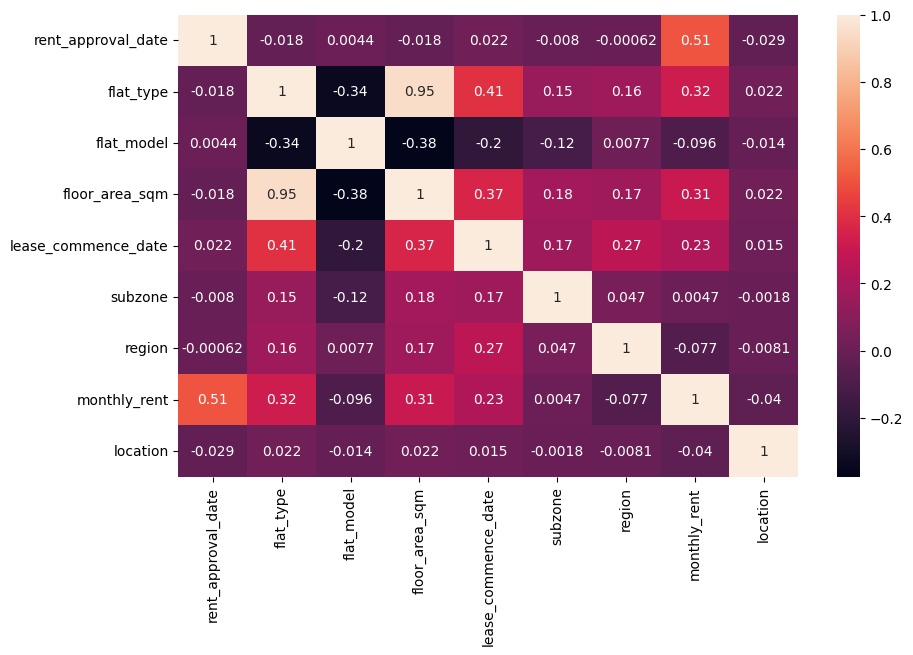

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 

training_data_raw = pd.read_csv('train.csv')
training_cleaned = clean_data(training_data_raw)

# columns_to_target_encode = ['flat_model', 'subzone', 'town', 'block', 'street_name', 'planning_area']
# myTargetEncoder = MyTargetEncoder(columns_to_target_encode, training_data_raw)

# df = myTargetEncoder.fit_data(training_cleaned)

df = training_cleaned
df = add_locations(df)
label_encoder = preprocessing.LabelEncoder()   
# Encode labels in column 'species'. 
df['region']= label_encoder.fit_transform(df['region'])
df['flat_model']= label_encoder.fit_transform(df['flat_model'])
df['subzone']= label_encoder.fit_transform(df['subzone'])
# df['town']= label_encoder.fit_transform(df['town'])
# df['block']= label_encoder.fit_transform(df['block'])
# df['street_name']= label_encoder.fit_transform(df['street_name'])
# df['planning_area']= label_encoder.fit_transform(df['planning_area'])



cor = df.corr()
plt.figure(figsize = (10, 6))
sns.heatmap(cor, annot=True)

In [122]:
sse, silhouette, ari = [], [], []
X = pd.read_csv('train.csv')
X = clean_data(X)
label_encoder = preprocessing.LabelEncoder()   
X['flat_model']= label_encoder.fit_transform(X['flat_model'])
X = X.loc[:,['latitude', 'longitude', 'flat_model']]

for k in tqdm(range(10, 25)):

    # Run K-Means for the current number of clusters k
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    
    # "inertia_" holds the sum of squared distances of samples to their closest cluster center
    # Record the current (k, sse) pair
    sse.append((k, kmeans.inertia_))
    
    # silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters    
    silhouette.append((k, silhouette_score(X, kmeans.labels_)))
    
# Convert to numpy array for convenience
sse = np.array(sse)
silhouette = np.array(silhouette)    
ari = np.array(ari)

100%|███████████████████████████████████████████| 15/15 [05:29<00:00, 21.97s/it]


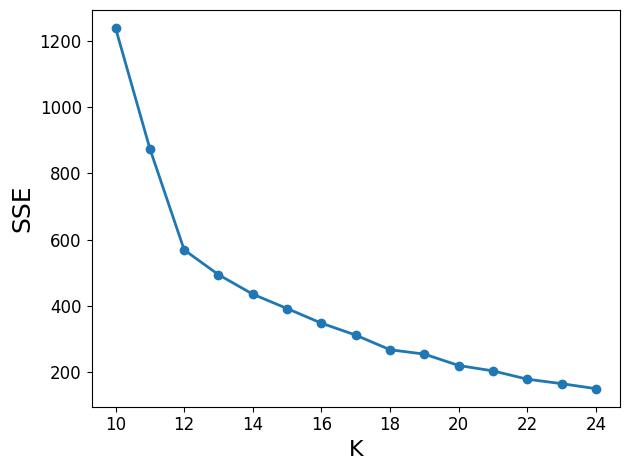

In [123]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('SSE', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in sse], [s[1] for s in sse], marker='o', lw=2)
plt.tight_layout()
plt.show()

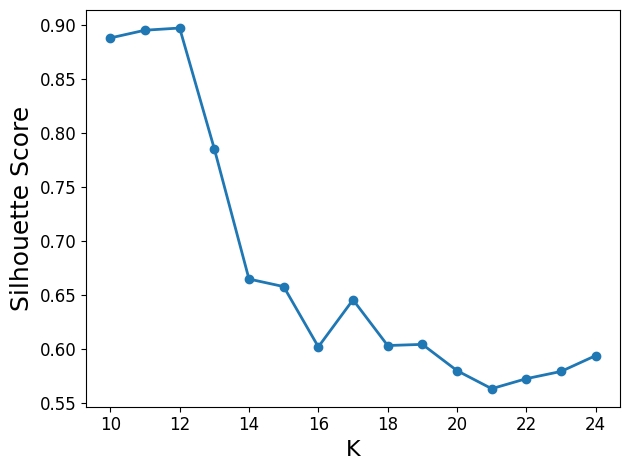

In [124]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in silhouette], [s[1] for s in silhouette], marker='o', lw=2)
plt.tight_layout()
plt.show()

<Axes: xlabel='latitude', ylabel='longitude'>

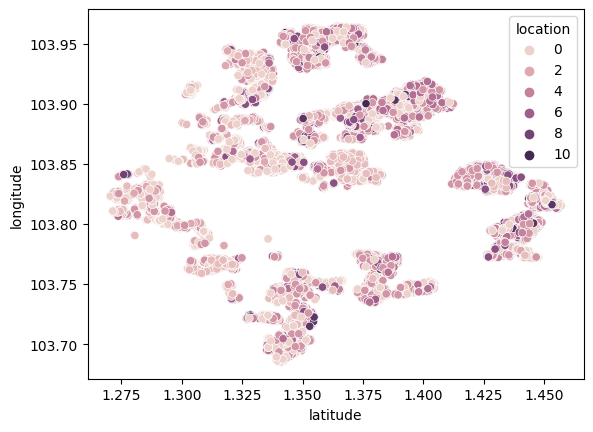

In [125]:
kmeans = KMeans(n_clusters=12, random_state=42)
X['location'] = kmeans.fit_predict(X[['latitude', 'longitude', 'flat_model']])
sns.scatterplot(data=X, x='latitude', y='longitude', hue='location')

In [126]:
X.head()

,latitude,longitude,flat_model,location
0,1.344518,103.738630,10,1
1,1.330186,103.938717,10,1
2,1.332242,103.845643,5,0
3,1.370239,103.962894,3,4
4,1.320502,103.863341,5,0


In [15]:
def add_locations(df):
    X = df.copy()
    kmeans = KMeans(n_clusters=12, random_state=42)
    label_encoder = preprocessing.LabelEncoder()   
    X['flat_model']= label_encoder.fit_transform(X['flat_model'])
    df['location'] = kmeans.fit_predict(X[['latitude', 'longitude', 'flat_model']])
    # df = df.drop(columns=['latitude', 'longitude'])
    return df

def add_locations_to_test(training, X):
    kmeans = KMeans(n_clusters=14, random_state=42)
    model = kmeans.fit(training[['latitude', 'longitude', 'monthly_rent']])
    X['location'] = kmeans.predict(X[['latitude', 'longitude']])
    # X = X.drop(columns=['latitude', 'longitude'])
    return X

<h1>XGBoost Trial</h1>

In [11]:
def prep_data_for_xgboost(issklearn=False):
    training_data_raw = pd.read_csv('train.csv')
    testing_data_raw = pd.read_csv('test.csv')

    #perform preprocessing
    training_data = preprocess_xgboost(training_data_raw, issklearn)

    train_X, train_y = training_data.drop('monthly_rent', axis=1), training_data[['monthly_rent']]
    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    X_test = preprocess_xgboost(testing_data_raw)

    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)
    print("Shape of testing data: ", X_test.shape)
    return X_train, y_train, X_val, y_val, X_test, train_X, train_y

def prep_data_for_xgboost_tencoding(issklearn=False):
    training_data_raw = pd.read_csv('train.csv')
    testing_data_raw = pd.read_csv('test.csv')

    # train_X, train_y = training_data.drop('monthly_rent', axis=1), training_data[['monthly_rent']]
    X_train, X_val = train_test_split(training_data_raw, test_size=0.2, random_state=42)
    
    X_train = preprocess_xgboost(X_train, issklearn)
    X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
    
    X_val = preprocess_xgboost_test(X_val)
    X_val, y_val = X_val.drop('monthly_rent', axis=1), X_val[['monthly_rent']]
    
    X_test = preprocess_xgboost_test(testing_data_raw)
    
    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)
    print("Shape of testing data: ", X_test.shape)
    return X_train, y_train, X_val, y_val, X_test

In [7]:
def train_xgboost(X_train, y_train, X_test, y_test, train_X, train_y):
    frmse = []
    cross_val_rmse = []
    # Define hyperparameters
    params = {"objective": "reg:squarederror", "tree_method": "hist"}
    
    for n in [5, 10, 15, 20]:
        dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
        dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
        evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
        model = xgb.train(
           params=params,
           dtrain=dtrain_reg,
           num_boost_round=n,
           verbose_eval=min(50, n),
            evals=evals
        )
        
        dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
        results = xgb.cv(
           params, dtrain_reg,
           num_boost_round=n,
           nfold=5,
           early_stopping_rounds=10
        )

        cross_val_rmse += [results['test-rmse-mean'].min()]
        
        preds = model.predict(dtest_reg)
        rmse = mean_squared_error(y_test, preds, squared=False)
        frmse.append(rmse)
    
        print(f"RMSE of the model: {rmse:.3f}")
    return (frmse, cross_val_rmse)

In [12]:
X_train, y_train, X_val, y_val, X_test = prep_data_for_xgboost_tencoding(True)

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)
Shape of testing data:  (30000, 20)


In [13]:
X_train.head()

,rent_approval_date,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,mrts_within_3km,nearest_distance_to_mrt,pri_schs_within_6km,gep_schs_within_5km,malls_within_3km,nearest_distance_to_gep,nearest_distance_to_mall,highest_pos_corr,region_central region,region_east region,region_north region,region_north-east region,region_west region
0,2107,3,2365.067275,67.0,1979,1.366600,103.855579,11,764.670207,52,2,11,1850.376297,1034.851528,10.227563,0.0,0.0,0.0,1.0,0.0
1,2201,5,2640.896729,110.0,2003,1.401158,103.751472,4,607.646696,25,0,11,9125.370545,597.191138,11.105234,0.0,0.0,0.0,0.0,1.0
2,2107,3,2365.067275,67.0,1978,1.316994,103.768507,8,423.362498,21,4,9,860.187654,247.035245,10.227563,0.0,0.0,0.0,0.0,1.0
3,2103,3,2614.410973,74.0,1984,1.347162,103.742808,6,775.808574,39,1,7,3701.476616,787.588358,10.104055,0.0,0.0,0.0,0.0,1.0
4,2206,4,2614.410973,93.0,2002,1.450165,103.819307,4,156.306323,27,0,5,10555.854553,218.614539,11.564181,0.0,0.0,1.0,0.0,0.0


In [106]:
rmse, cross_val_rmse = train_xgboost(X_train, y_train, X_val, y_val, train_X, train_y)

[0]	validation-rmse:614.04832	train-rmse:617.96581
[4]	validation-rmse:501.01414	train-rmse:496.87932
RMSE of the model: 501.014
[0]	validation-rmse:614.04832	train-rmse:617.96581
[9]	validation-rmse:488.07014	train-rmse:475.89107
RMSE of the model: 488.070
[0]	validation-rmse:614.04832	train-rmse:617.96581
[14]	validation-rmse:486.54751	train-rmse:468.75509
RMSE of the model: 486.548
[0]	validation-rmse:614.04832	train-rmse:617.96581
[19]	validation-rmse:485.93894	train-rmse:465.18422
RMSE of the model: 485.939


In [107]:
rmse, cross_val_rmse

([501.0141421866612,
  488.07014526012216,
  486.5475144133869,
  485.93893669466604],
 [503.6018400837003, 488.9152356569146, 486.6702351305422, 486.38728162172504])

<h1>XGBoost sklearn Trial</h1>

In [15]:
X_train, y_train, X_val, y_val, X_test = prep_data_for_xgboost_tencoding(True)

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)
Shape of testing data:  (30000, 20)


In [16]:
X_train

,rent_approval_date,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,mrts_within_3km,nearest_distance_to_mrt,pri_schs_within_6km,gep_schs_within_5km,malls_within_3km,nearest_distance_to_gep,nearest_distance_to_mall,highest_pos_corr,region_central region,region_east region,region_north region,region_north-east region,region_west region
0,2107,3,2365.067275,67.0,1979,1.366600,103.855579,11,764.670207,52,2,11,1850.376297,1034.851528,10.227563,0.0,0.0,0.0,1.0,0.0
1,2201,5,2640.896729,110.0,2003,1.401158,103.751472,4,607.646696,25,0,11,9125.370545,597.191138,11.105234,0.0,0.0,0.0,0.0,1.0
2,2107,3,2365.067275,67.0,1978,1.316994,103.768507,8,423.362498,21,4,9,860.187654,247.035245,10.227563,0.0,0.0,0.0,0.0,1.0
3,2103,3,2614.410973,74.0,1984,1.347162,103.742808,6,775.808574,39,1,7,3701.476616,787.588358,10.104055,0.0,0.0,0.0,0.0,1.0
4,2206,4,2614.410973,93.0,2002,1.450165,103.819307,4,156.306323,27,0,5,10555.854553,218.614539,11.564181,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,2305,5,2705.014677,110.0,2001,1.450242,103.817316,3,341.716096,27,0,6,10694.212394,329.246531,13.451103,0.0,0.0,1.0,0.0,0.0
47996,2112,3,2614.410973,74.0,1985,1.353027,103.936584,8,752.650931,48,1,8,381.658748,399.016862,10.573415,0.0,1.0,0.0,0.0,0.0
47997,2301,6,2879.023508,147.0,1994,1.364042,103.952424,7,902.294534,33,1,9,2417.797345,963.228089,13.204804,0.0,1.0,0.0,0.0,0.0
47998,2107,3,2365.067275,67.0,1982,1.331839,103.912365,12,555.483997,52,1,8,3292.549664,2014.857366,10.227563,0.0,1.0,0.0,0.0,0.0


In [28]:
xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=5, eta=0.01, subsample=0.8, colsample_bytree=0.7,
            objective="reg:squarederror"
        )

xgb_model.fit(X_train, y_train)
y_val_pred = xgb_model.predict(X_val)
print('Validation loss:', np.sqrt(mean_squared_error(y_val, y_val_pred)))
y_train_pred = xgb_model.predict(X_train)
print('Training loss:', np.sqrt(mean_squared_error(y_train, y_train_pred)))

Validation loss: 481.66300965784643
Training loss: 464.5457890602582


<h2>Params</h2>

In [67]:
for depth in range(3, 10):
    xgb_model = xgb.XGBRegressor(
            n_estimators=1200, max_depth=depth, eta=0.01, subsample=0.7, colsample_bytree=0.7,
            objective="reg:squarederror"
        )

    xgb_model.fit(X_train, y_train)
    y_val_pred = xgb_model.predict(X_val)
    print(depth, ":", np.sqrt(mean_squared_error(y_val, y_val_pred)))

3 : 484.3208703045086
4 : 482.6904954996256
5 : 481.88424552380235
6 : 482.08004505708965
7 : 483.3807213938884
8 : 485.90316334989893
9 : 489.64492205016626


In [72]:
e = [1200, 1500, 2000, 2200, 2400]
for es in e:
    print('------ Estimators: ', es, '------')
    for depth in range(3, 10):
        xgb_model = xgb.XGBRegressor(
                n_estimators=es, max_depth=depth, eta=0.01, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        print(depth, ":", np.sqrt(mean_squared_error(y_val, y_val_pred)))

------ e:  1200 ------
3 : 484.3208703045086
4 : 482.6904954996256
5 : 481.88424552380235
6 : 482.08004505708965
7 : 483.3807213938884
8 : 485.90316334989893
9 : 489.64492205016626
------ e:  1500 ------
3 : 483.761700205445
4 : 482.161295157774
5 : 481.68032982833165
6 : 482.1763187173511
7 : 483.98659869799485
8 : 487.3905417216456
9 : 492.10949955577007
------ e:  2000 ------
3 : 483.23384101988836
4 : 481.799675529969
5 : 481.6320861942577
6 : 482.83419863831233
7 : 485.5376804335166
8 : 490.3271834464959
9 : 496.60100663339364
------ e:  2200 ------
3 : 483.0769877911771
4 : 481.7076161177126
5 : 481.6478853345284
6 : 483.1648539666555
7 : 486.1982935596532
8 : 491.6250244849866
9 : 498.42630612822194
------ e:  2400 ------
3 : 482.90988875237355
4 : 481.62569292426235
5 : 481.7644754705415
6 : 483.54756549373377
7 : 486.9871710937626
8 : 492.8483995169246
9 : 500.20391481010853


In [76]:
e = [2200, 2400, 2600]
for es in e:
    print('------ Estimators: ', es, '------')
    for depth in range(7, 12):
        xgb_model = xgb.XGBRegressor(
                n_estimators=es, max_depth=depth, eta=0.001, subsample=0.7, colsample_bytree=0.7,
                objective="reg:squarederror"
            )
    
        xgb_model.fit(X_train, y_train)
        y_val_pred = xgb_model.predict(X_val)
        print(depth, ":", np.sqrt(mean_squared_error(y_val, y_val_pred)))

------ Estimators:  2200 ------
7 : 489.920885420012
8 : 489.1185856273731
9 : 489.0521820614209
10 : 489.79460727877483
11 : 491.1473684431389
------ Estimators:  2400 ------
7 : 487.9624546213078
8 : 487.36320743615016
9 : 487.4753153168314
10 : 488.3836186581686
11 : 489.9247181371108
------ Estimators:  2600 ------
7 : 486.56112413997727


KeyboardInterrupt: 

<h1>Gradient Boosting</h1>

In [184]:
X_train, y_train, X_val, y_val, X_test, train_X, train_y = prep_data_for_xgboost_tencoding(True)

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)
Shape of testing data:  (30000, 20)


In [185]:
X_train

,rent_approval_date,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,mrts_within_3km,nearest_distance_to_mrt,pri_schs_within_6km,gep_schs_within_5km,malls_within_3km,nearest_distance_to_gep,nearest_distance_to_mall,highest_pos_corr,region_central region,region_east region,region_north region,region_north-east region,region_west region
0,2107,3,2365.067275,67.0,1979,1.366600,103.855579,11,764.670207,52,2,11,1850.376297,1034.851528,10.227563,0.0,0.0,0.0,1.0,0.0
1,2201,5,2640.896729,110.0,2003,1.401158,103.751472,4,607.646696,25,0,11,9125.370545,597.191138,11.105234,0.0,0.0,0.0,0.0,1.0
2,2107,3,2365.067275,67.0,1978,1.316994,103.768507,8,423.362498,21,4,9,860.187654,247.035245,10.227563,0.0,0.0,0.0,0.0,1.0
3,2103,3,2614.410973,74.0,1984,1.347162,103.742808,6,775.808574,39,1,7,3701.476616,787.588358,10.104055,0.0,0.0,0.0,0.0,1.0
4,2206,4,2614.410973,93.0,2002,1.450165,103.819307,4,156.306323,27,0,5,10555.854553,218.614539,11.564181,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,2305,5,2705.014677,110.0,2001,1.450242,103.817316,3,341.716096,27,0,6,10694.212394,329.246531,13.451103,0.0,0.0,1.0,0.0,0.0
47996,2112,3,2614.410973,74.0,1985,1.353027,103.936584,8,752.650931,48,1,8,381.658748,399.016862,10.573415,0.0,1.0,0.0,0.0,0.0
47997,2301,6,2879.023508,147.0,1994,1.364042,103.952424,7,902.294534,33,1,9,2417.797345,963.228089,13.204804,0.0,1.0,0.0,0.0,0.0
47998,2107,3,2365.067275,67.0,1982,1.331839,103.912365,12,555.483997,52,1,8,3292.549664,2014.857366,10.227563,0.0,1.0,0.0,0.0,0.0


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(
            n_estimators=200, learning_rate=0.1, min_samples_split=500,min_samples_leaf=60,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
        )

gb_model.fit(X_train, y_train)
y_val_pred = gb_model.predict(X_val)
print('Validation loss:', np.sqrt(mean_squared_error(y_val, y_val_pred)))
y_train_pred = gb_model.predict(X_train)
print('Training loss:', np.sqrt(mean_squared_error(y_train, y_train_pred)))


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation loss: 482.57352582549424
Training loss: 456.47080437744125


<h1>Random Forest</h1>

In [252]:
X_train, y_train, X_val, y_val, X_test, train_X, train_y = prep_data_for_xgboost_tencoding(True)

Shape of training data:  (48000, 20)
Shape of training label:  (48000, 1)
Shape of validation data:  (12000, 20)
Shape of validation label:  (12000, 1)
Shape of testing data:  (30000, 20)


In [246]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(6, 10, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [450, 500, 550]
# Minimum number of samples required at each leaf node
min_samples_leaf = [40, 50, 60]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['sqrt'], 'max_depth': [6, 7, 8, 9, 10], 'min_samples_split': [450, 500, 550], 'min_samples_leaf': [40, 50, 60], 'bootstrap': [True]}


In [250]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [40, 50, 60],
                                        'min_samples_split': [450, 500, 550],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, verbose=2)

In [251]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 450,
 'min_samples_leaf': 40,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [30]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, min_samples_split=450, min_samples_leaf=40, max_features='sqrt', max_depth=10, bootstrap=True)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print('Validation loss:', np.sqrt(mean_squared_error(y_val, y_val_pred)))
y_train_pred = model.predict(X_train)
print('Training loss:', np.sqrt(mean_squared_error(y_train, y_train_pred)))

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Validation loss: 495.13194113707726
Training loss: 492.9563384976647
